In [3]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.utils.fixes import parse_version, sp_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.interpolate import UnivariateSpline

In [4]:
var = {
        "observational_attribute": "tsl",
        "units": "K",
}

column_names_mod = [
    'Ts_5cm',
    'Ts_15cm',	
    'Ts_25cm',	
    'Ts_35cm',	
    'Ts_45cm',	
    'Ts_80cm',
    'Ts_120cm'
]

column_names_obs = [ 
    "TIMESTAMP", 
    'Ts_5cm',
    'Ts_10cm',	
    'Ts_20cm',	
    'Ts_40cm',	
    'Ts_80cm',	
    'Ts_120cm'
]

resolution_dict = {
    "halfhourly":"30min",
    'daily': "D",
    "monthly": "ME"
}

resolution_label = {
    "halfhourly":"30 мин",
    'daily': "сутки",
    "monthly": "месяц"
}

scenarios = [
    "ND",
    "LD",
    "MD",
    "HD"
]

# Список новых глубин
new_depths = [10, 20, 40]

In [5]:
def spline_interpolate_depths(df, new_depths):

    """ 
    Функция для приведения модельных темератур к глубинам измеренных температур
    Использована интерполяция типа сплайн
    """

    # Извлекаем существующие глубины из названий колонок и преобразуем в числа
    existing_depths = [int(col.split('Ts_')[1].replace('cm','')) for col in df.columns]
    
    # Создание DataFrame для хранения интерполированных данных
    df_interpolated = pd.DataFrame(index=df.index)
    
    # Добавляем исходные колонки в новый DataFrame
    for col in df.columns:
        df_interpolated[col] = df[col]
    
    # Проходимся по каждому временному индексу и интерполируем значения для новых глубин
    for index, row in df.iterrows():
        # Используем данные по глубинам и температурам для текущего времени
        depths = np.array(existing_depths)
        temps = row.values
        
        # Создаем функцию для сплайн-интерполяции
        spline = interp1d(depths, temps, kind='cubic', fill_value="extrapolate")
        
        # Интерполируем для каждой новой глубины
        for new_depth in new_depths:
            interpolated_temp = spline(new_depth)
            df_interpolated.at[index, f'Ts_{new_depth}cm'] = interpolated_temp
    
    return df_interpolated

def linear_interpolate_depths(df, new_depths):

    """ 
    Функция для линейной интерполяции как альтернатива сплайну
    """

    existing_depths = [int(col.split('Ts_')[1].replace('cm','')) for col in df.columns]
    depths_df = pd.DataFrame({'depth': existing_depths, 'column': df.columns})
    
    # Создание нового DataFrame для хранения результатов
    df_interpolated = df.copy()
    
    for new_depth in new_depths:
        # Находим ближайшие существующие глубины
        below = depths_df[depths_df['depth'] < new_depth].max()['depth']
        above = depths_df[depths_df['depth'] > new_depth].min()['depth']
        
        # Находим названия колонок для этих глубин
        col_below = depths_df[depths_df['depth'] == below]['column'].values[0]
        col_above = depths_df[depths_df['depth'] == above]['column'].values[0]
        
        # Выполняем линейную интерполяцию
        df_interpolated[f'Ts_{new_depth}cm'] = df_interpolated[col_below] + (df_interpolated[col_above] - df_interpolated[col_below]) * ((new_depth - below) / (above - below))
    
    return df_interpolated

def generate_plot(ax, dataframe_obs, dataframes_model, var, soil_layer, resolution_plot, year):
    """ 
    Функция для построения графика температур модельных и наблюдения
    """
    # Настройка заголовка графика
    title = f"Глубина {soil_layer[3:]}"
    ax.plot(dataframe_obs[soil_layer],  ls="-.", lw=0.5, ms=3, label = "Данные наблюдения", color='black')
    # строим графики отдельно для каждого сценария
    for scenario, df_model in dataframes_model.items():
        ax.plot(df_model[soil_layer], ls="-", lw=0.5, ms=3, label=f"CLASSIC {scenario}")
    
    ax.set_title(title)
    # ax.set_xlabel('Время')
    ax.set_ylabel("Температура (℃)")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(loc = "upper left")

def process_files (resolution_process, year, obs_folder, experiment_name, 
                   var = var, column_names_obs = column_names_obs, 
                   resolution_dict = resolution_dict, scenarios = scenarios, new_depths = new_depths, 
                   interpolation = spline_interpolate_depths, show = True):
    """ 
    Функция для обработки результатов моделирования по разным сценариям
    и результатов наблюдения
    """
    print(f"Processing year {year}" + " observed data...")
    # читаем файл с данными наблюдения
    obs_dir = [f for f in os.listdir(obs_folder+'/') if f.startswith(str(year)) and f.endswith(".csv")]
    df_obs_full = pd.read_csv(obs_folder+'/'+obs_dir[0],skiprows=[1], usecols=column_names_obs)
    df_obs_full['time'] = pd.to_datetime(df_obs_full['TIMESTAMP'])
    # устанавливаем время как индекс
    df_obs_full = df_obs_full.set_index ('time')
    # заменяем пустые значения на No data
    df_obs_full.replace(-6999, np.nan, inplace=True)
    df_obs_full = df_obs_full.drop(['TIMESTAMP'], axis=1)
    df_obs_resampled = df_obs_full.resample(resolution_dict[resolution_process]).mean()

    print(f"Processing {year}" + " modelled data...")

    dataframes_model = {}
    for scenario in scenarios:
        df_modelled = xr.open_dataset(f'/home/babykelp/eccc/{experiment_name}/{resolution_process}/tsl_{resolution_process}_{scenario}.nc')
        df_modelled = df_modelled.tsl.values.squeeze()
        start_date = '2019-01'
        n_periods = df_modelled.shape[0]
        time_index = pd.date_range(start=start_date, periods=n_periods, freq=resolution_dict[resolution_process])
        df_modelled_rsltn = pd.DataFrame(df_modelled, index=time_index, columns=column_names_mod)
        # Вызов функции интерполяции
        df_interpolated = interpolation(df_modelled_rsltn, new_depths)
        df_modelled_rsltn = df_interpolated.loc[f'{year-1}-12-31 19:00':f'{year}-12-31']
        df_modelled_celcius = df_modelled_rsltn - 273.16
        df_modelled_celcius.index = df_modelled_celcius.index + pd.Timedelta(hours=5)

        dataframes_model[scenario] = df_modelled_celcius

    if show:
        print("Generating timeseries plots...")
        fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(10, 20), constrained_layout=True)
        for idx, sl in enumerate(column_names_obs[1:]):
            generate_plot(axs[idx], df_obs_resampled, dataframes_model, var, sl, resolution_process, year)
    
    return dataframes_model, df_obs_resampled

def mse_f (df_obs, df_model, column_names_obs = column_names_obs):
    """ 
    Функция для рассчёта среднеквадратичной ошибки MSE
    """
    #фильтруем данные
    df_obs = df_obs.dropna()
    df_model = df_model.loc[df_obs.index]

    mse = {}
    for col in column_names_obs[1:]:
        mse[col] = (((df_obs[col] - df_model[col]) ** 2).mean())**(1/2)
    
    return mse

def plot_conditional_quantile_plots (observed_df, modelled_df, layers, spline = True):
    
    """ 
    Функция для построения диаграмм рассеяния, расчёта корреляции, линии среднего и квантилей
    Если spline = True, линия среднего будет построена с помощью UnivariateSpline
    """

    #фильтруем данные 
    observed_df = observed_df.dropna()
    modelled_df = modelled_df.loc[observed_df.index]

    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(10, 20), constrained_layout=True)
    
    # Цикл по всем слоям почвы
    for idx, layer in enumerate(layers):
        ax = axs[idx, 0]
        ax1 = axs[idx, 1]

        X = observed_df[layer].values.reshape(-1, 1)
        y_mean = modelled_df[layer].values

        y_lin_regr = LinearRegression()
        y_lin_regr.fit(X, y_mean)
        y_lin_regr = y_lin_regr.predict(X)

        # Создадим сплайн для средней линии
        X_sort = np.sort(X)
        mean_spline = UnivariateSpline(X_sort, y_mean, s=1)  # гладкость
        y_spline = mean_spline(X_sort)

        # Считаем квантили для данных наблюдения и моделирования
        quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]  
        predictions = {}
        splines = {}
        
        for quantile in quantiles:
            qr = QuantileRegressor(quantile=quantile, alpha=0, solver = solver)
            y_pred = qr.fit(X, y_mean).predict(X)
            predictions[quantile] = y_pred

            # Теперь создаем сплайн
            quantile_spline = UnivariateSpline(X_sort, y_pred, s=1)
            splines[quantile] = quantile_spline(X_sort)
            
        color_palette = ['#0e2d69ff', '#11a0d7ff', "#029c63ff", '#7d4ebaff','#eb681fff', '#e61f3dff', "#7da0d3ff"]
        if not spline:
            ax.plot(X, predictions[0.10], label=f"Квантиль: 0,1", color=color_palette[0], linestyle='dotted', linewidth=1.5)
            ax.plot(X, predictions[0.90], label=f"Квантиль: 0,9", color=color_palette[0], linestyle='dotted', linewidth=1.5)
        # ax.plot(X, predictions[0.25], label=f"Квантиль: 0,25", color=color_palette[4], linestyle='dashdot', linewidth=1.5)
        # ax.plot(X, predictions[0.75], label=f"Квантиль: 0,75", color=color_palette[5], linestyle='dashdot', linewidth=1.5)
        # ax.plot(X, predictions[0.50], label=f"Квантиль 0,5", color=color_palette[5], linestyle='solid', linewidth=1.5)

        ax.scatter(
            X,
            y_mean,
            color='gray',
            marker="+",
            alpha=0.2,
        )
        resid = observed_df[layer] - modelled_df[layer]
        if spline:
            ax.plot(X_sort, y_spline, color="red", label="Среднее")
        else:
            ax.plot(X, y_lin_regr, color="red", label="Среднее")
        ax1.hist(resid, color=color_palette[0], bins = 20, alpha = 0.5)
        ax1.axvline(resid.mean(), label = "Среднее", color=color_palette[5])
        ax1.axvline(np.percentile(resid.values, 25), label=f"Квантиль: 0,25", color=color_palette[0], linestyle='dashdot', linewidth=1.5)
        ax1.axvline(np.percentile(resid.values, 75), label=f"Квантиль: 0,75", color=color_palette[0], linestyle='dashdot', linewidth=1.5)
        # Добавляем диагональную линию
        ax.plot([X.min(), X.max()], 
                [X.min(), X.max()], 
                color='black', linestyle='solid', linewidth=1.5, label='Линия 1:1')
        
        # подписи
        if idx == 0:
            ax.set_title(f'Глубина: {layer[-3:-2]} см') 
        elif idx == 5:
            ax.set_title(f'Глубина: {layer[-5:-2]} см')
        else:
            ax.set_title(f'Глубина: {layer[-4:-2]} см')
        ax1.set_title("Данные наблюдения - данные моделирования")
        ax.legend()
        ax1.legend()
        ax.set_xlabel("Данные наблюдения")
        ax1.set_xlabel("Остатки")
        ax.set_ylabel("Данные моделирования")

        r2 = r2_score(X, y_mean)
        print(f"{layer} =", r2)
        ax.text(6, -2.5, f"r2 = {r2:.2f}")

    plt.show()

def seasons_mse (df_mod, df_obs):
    
    """ 
    Функция для расчёта RMSE по месяцам
    """

    months = ['Jan',"Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov","Dec"]
    seasons_mse = pd.DataFrame(index = months, columns = column_names_obs[1:])
    for m, month_name in enumerate(months, start=1):
        # Отбираем данные за определенный месяц
        mod_month = df_mod[df_mod.index.month == m]
        obs_month = df_obs[df_obs.index.month == m]
        
        # Рассчитываем MSE
        if not mod_month.empty and not obs_month.empty:
            mse = mse_f(obs_month, mod_month, column_names_obs)
            seasons_mse.loc[month_name] = mse
    return seasons_mse

In [6]:
observed_data_folder = "observed_data"
experiment_name = "experiment_8_grass_albedo"

Processing year 2019 observed data...
Processing 2019 modelled data...
Generating timeseries plots...
Processing year 2019 observed data...
Processing 2019 modelled data...
Generating timeseries plots...
Processing year 2019 observed data...
Processing 2019 modelled data...
Generating timeseries plots...


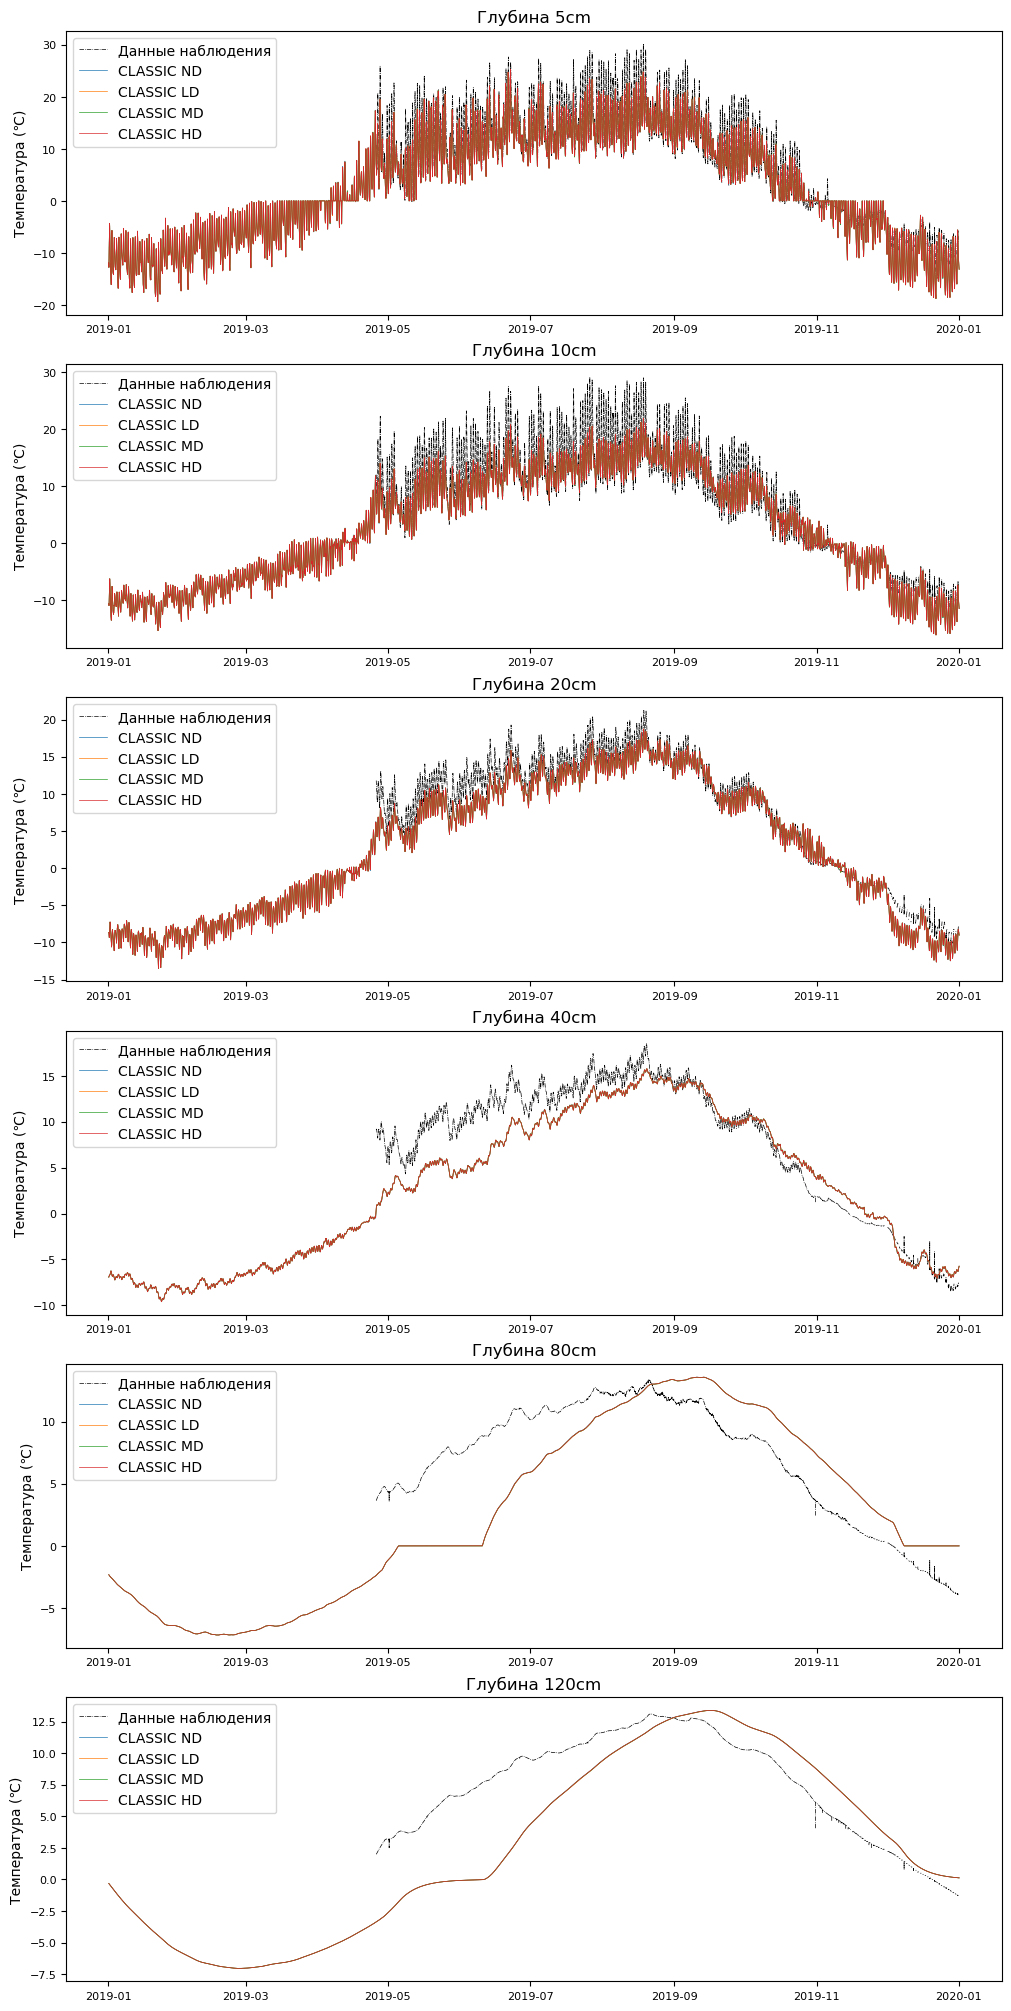

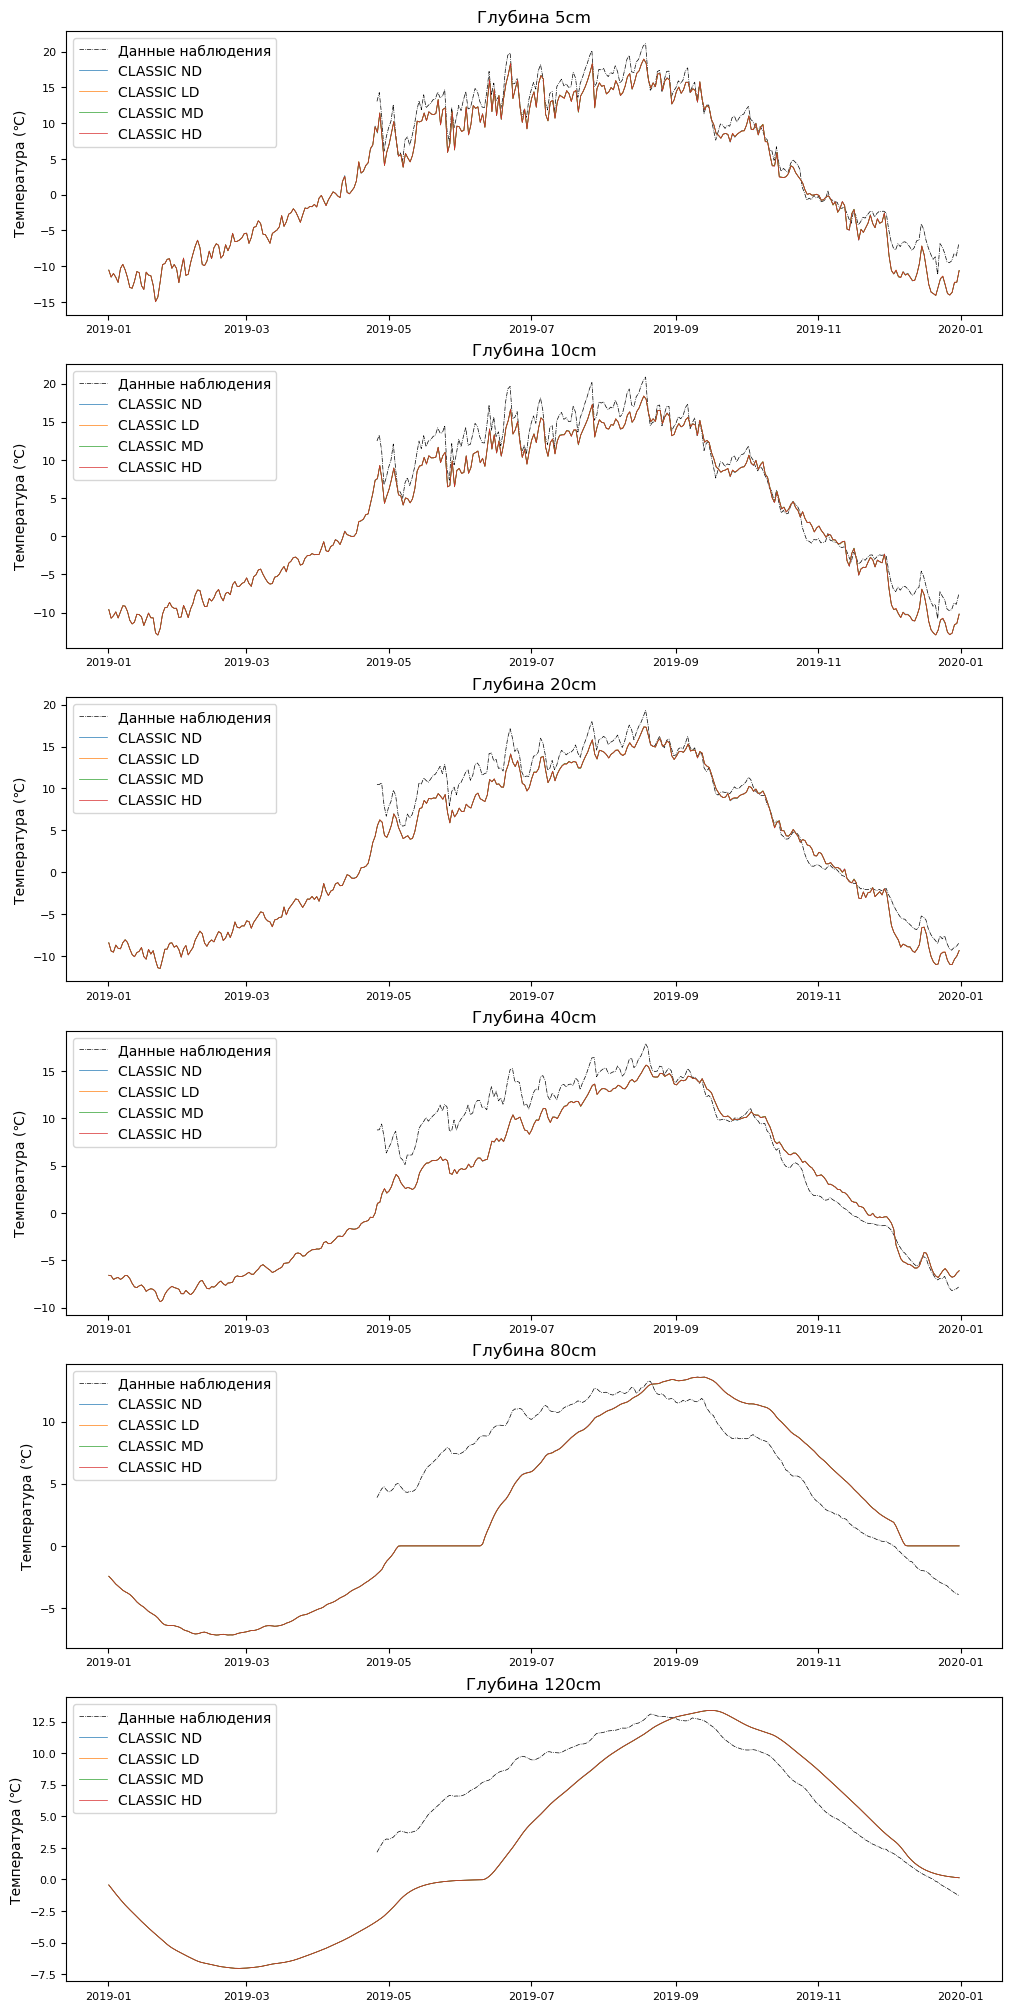

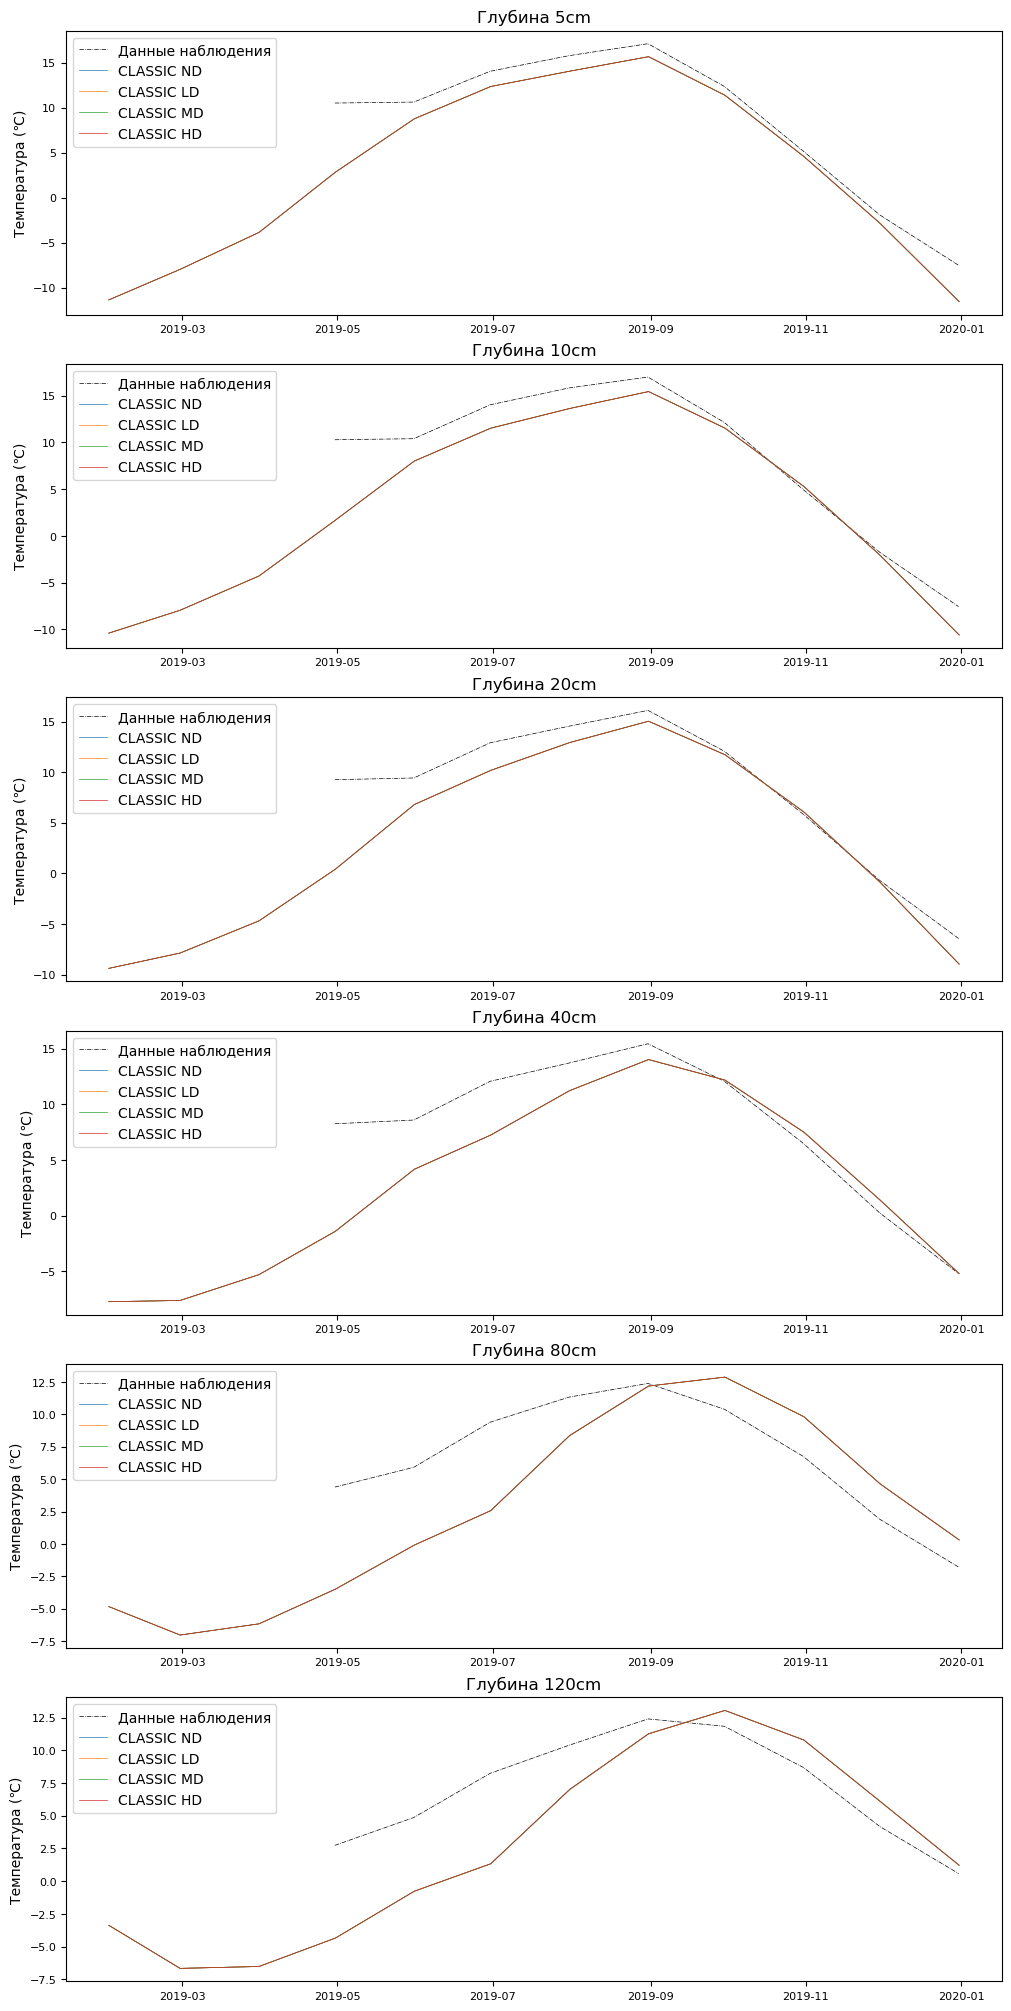

In [10]:
### графики и ошибка в 2019 году
for resolution in resolution_dict:
    process_files(resolution, 2019, observed_data_folder, experiment_name)

In [8]:
dfs_model_2019, df_obs_2019 = process_files("halfhourly", 2019, observed_data_folder, experiment_name, show = False)

dfs_model_2019_ND = dfs_model_2019['ND']
dfs_model_2019_ND = dfs_model_2019_ND.loc["2019-04-26":]

mse_2019 = mse_f(df_obs_2019, dfs_model_2019_ND)
mse_2019

Processing year 2019 observed data...
Processing 2019 modelled data...


{'Ts_5cm': 3.5680750501906444,
 'Ts_10cm': 2.9487179381799615,
 'Ts_20cm': 1.999487405991824,
 'Ts_40cm': 2.9982947181274793,
 'Ts_80cm': 4.169119349644345,
 'Ts_120cm': 3.8592228627333203}

In [9]:
seasons_mse_2019 = seasons_mse(dfs_model_2019_ND, df_obs_2019)

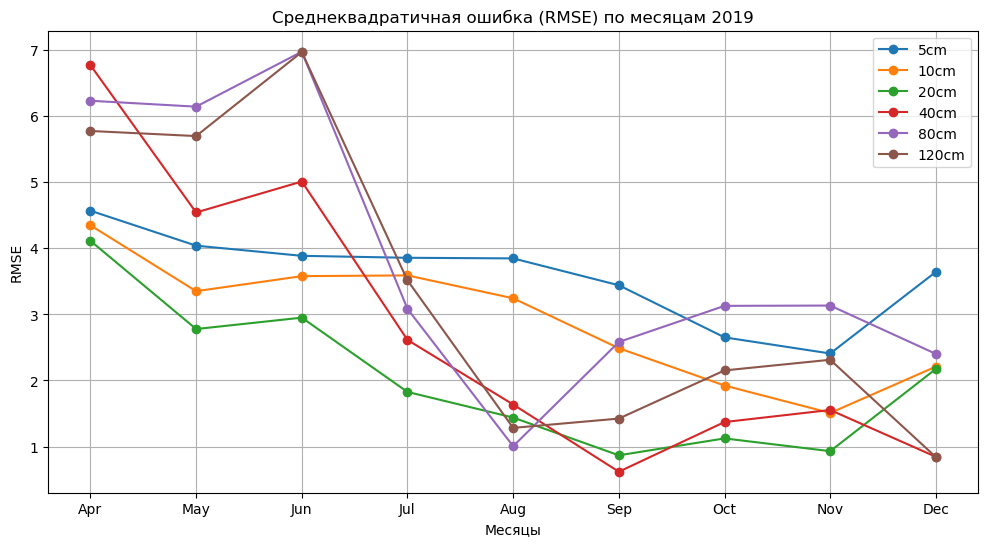

In [10]:
# Построим график для DataFrame с MSE по месяцам
plt.figure(figsize=(12, 6))
for col in seasons_mse_2019.columns:
    plt.plot(seasons_mse_2019.index, seasons_mse_2019[col], label=col[3:], marker='o')

plt.title('Среднеквадратичная ошибка (RMSE) по месяцам 2019')
plt.xlabel('Месяцы')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()  # Отобразим график

Ts_5cm = 0.8315526992883423
Ts_10cm = 0.8787332697547455
Ts_20cm = 0.9155828054498752
Ts_40cm = 0.7607090766604401
Ts_80cm = 0.037548132461300066
Ts_120cm = -0.08358877312145507


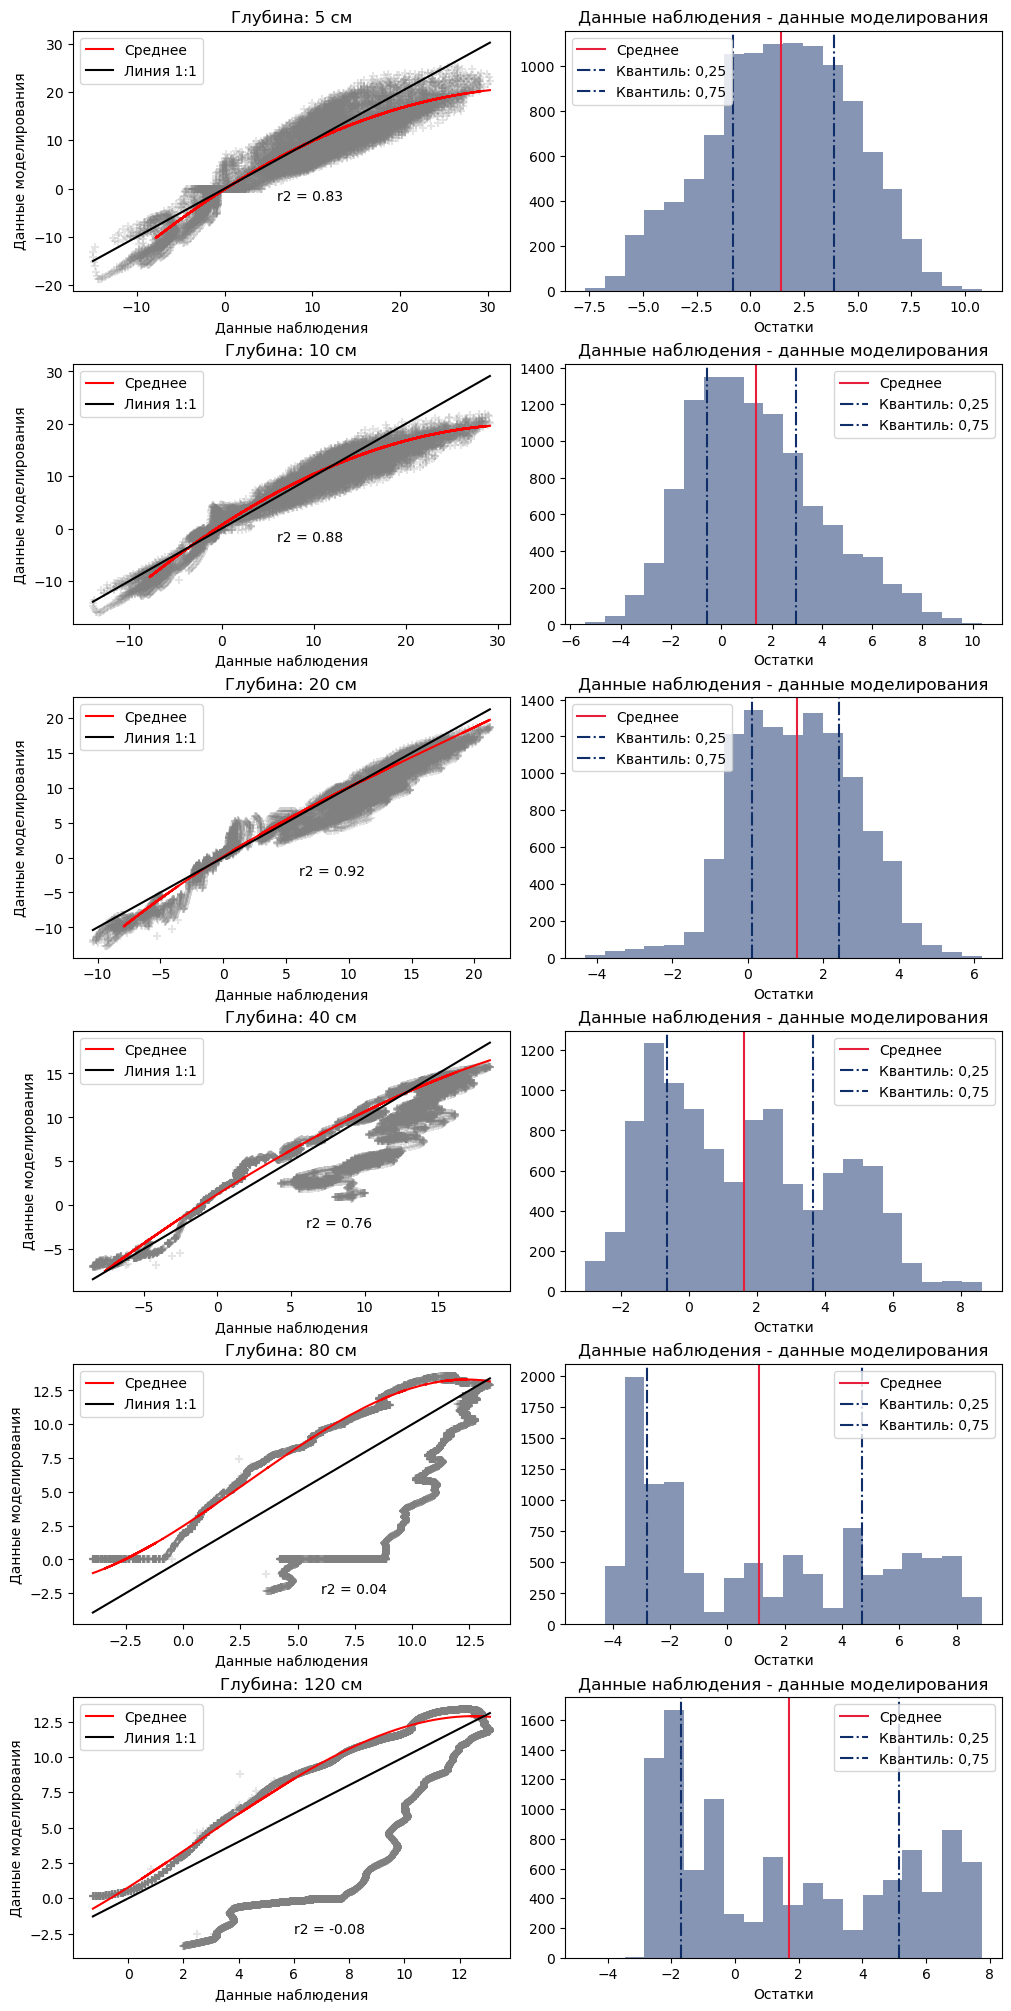

In [12]:
plot_conditional_quantile_plots(df_obs_2019, dfs_model_2019_ND, column_names_obs[1:], spline = True)

In [17]:
### графики и ошибка в 2021 году
for resolution in resolution_dict:
    process_files(resolution, 2021, observed_data_folder, experiment_name)

Processing year 2021 observed data...
Processing 2021 modelled data...
Generating timeseries plots...
Processing year 2021 observed data...
Processing 2021 modelled data...
Generating timeseries plots...
Processing year 2021 observed data...
Processing 2021 modelled data...
Generating timeseries plots...


In [11]:
dfs_model_2021, df_obs_2021 = process_files("halfhourly", 2021, observed_data_folder, experiment_name, show = False)

dfs_model_2021_ND = dfs_model_2021['ND']
# dfs_model_2021_ND = dfs_model_2021_ND.loc[:"2021-10-13"]
mse_2021 = mse_f(df_obs_2021, dfs_model_2021_ND)
mse_2021

Processing year 2021 observed data...
Processing 2021 modelled data...


{'Ts_5cm': 4.022104997050936,
 'Ts_10cm': 3.4511322484023172,
 'Ts_20cm': 2.3620727944664472,
 'Ts_40cm': 2.8899631120622424,
 'Ts_80cm': 3.513908474379435,
 'Ts_120cm': 3.9096400517954284}

In [13]:
seasons_mse_2021 = seasons_mse(dfs_model_2021_ND, df_obs_2021)
# Построим график для DataFrame с MSE по месяцам
plt.figure(figsize=(12, 6))
for col in seasons_mse_2021.columns:
    plt.plot(seasons_mse_2021.index, seasons_mse_2021[col], label=col[3:], marker='o')

plt.title('Среднеквадратичная ошибка (RMSE) по месяцам 2021')
plt.xlabel('Месяцы')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()  # Отобразим график

Ts_5cm = 0.858282008169802
Ts_10cm = 0.8958744251010685
Ts_20cm = 0.9374417875218936
Ts_40cm = 0.8947336253603161
Ts_80cm = 0.7498466417640188
Ts_120cm = 0.6041512881623088


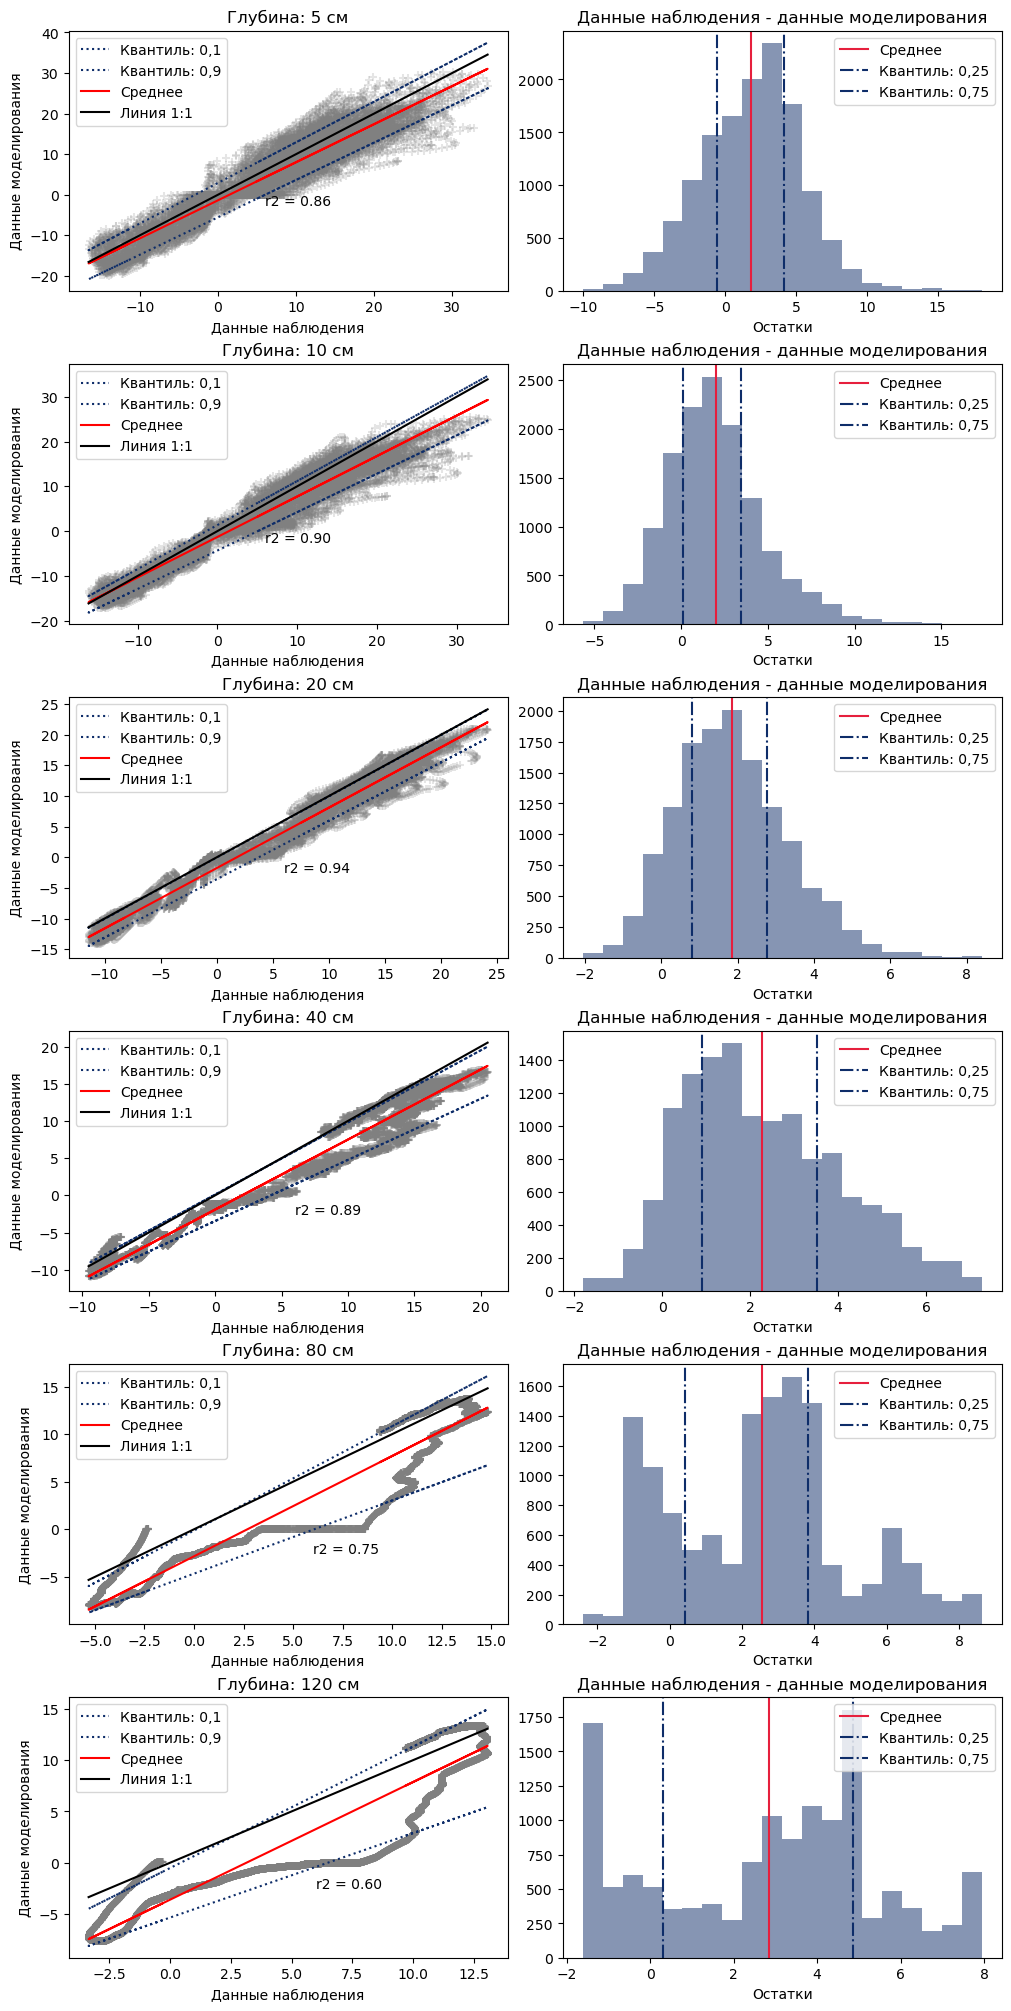

In [15]:
plot_conditional_quantile_plots(df_obs_2021, dfs_model_2021_ND, column_names_obs[1:], spline = False)